# Лаборная работа 2

## 1. Методы понижения дисперсии оценок

### Задание 1

Пусть имеется $n+m$ клеток некоторой ткани. При этом клетки $1, \ldots, n$ являются злокачественными, а клетки $n+1, \ldots, n+m$ - здоровыми. В результате проведения терапии клетка $i=1, \ldots, n+m$ погибает через время $T_i$, имеющее показательное распределение с параметром $\lambda_i$. Случайные величины $T_1, \ldots, T_{n+m}$ предполагаются независимыми. Пусть в некоторый момент времени все злокачественные клетки погибли, требуется вычислить оценку вероятности того, что число оставшихся здоровых клеток $N$ превысит некоторое заданное значение $k$:  
$$\mathbb{P}(N \geq k)=\mathbb{P}\left(\max _{i \leq n} T_i<T^{(k)}\right)$$

где $T^{(k)}-k$-ая по величине из значений $T_{n+1}, \ldots, T_{n+m}$, т. е.
$$T^{(1)} \geq T^{(2)} \geq \cdots \geq T^{(k)} \geq \cdots \geq T^{(m)}$$

Для оценки искомой вероятности воспользоваться условным методом Монте-Карло, предварительно получив выражение для условной вероятности
$$\mathbb{P}\left(N \geq k \mid T^{(k)}\right)$$

In [36]:
import numpy as np
import random

# параметры задачи
n = 10  # количество злокачественных клеток
m = 200  # количество здоровых клеток
k = 25  # минимальное количество оставшихся здоровых клеток
lambdas_bad = np.random.uniform(0.1, 0.5, n)  # лямбды для злокачественных клеток
lambdas_healthy = np.random.uniform(0.05, 0.4, m)  # лямбды для здоровых клеток

# количество экспериментов Монте-Карло
n_count = 10000

In [37]:
# счетчик для оценки вероятности
probabilities = np.zeros(n_count)

for i in range(n_count):
    # генерация времен гибели здоровых клеток
    times = np.random.exponential(scale=1 / np.array(lambdas_healthy))

    # находим момент, когда осталось k здоровых клеток (T^k)
    times_sort = np.sort(times)
    t_k = times_sort[m-k]

    # находим условную вероятность P(N >= k | T^(k))
    # то есть вероятность что все злокачественные клетки погибнут раньше чем k-тая здоровая клетка
    prob = np.prod(1 - np.exp(-np.array(lambdas_bad) * t_k))
    probabilities[i] = prob

# оценка вероятности P(N >= k) как среднее условных вероятностей
prob_est = np.mean(probabilities)
print(f"Оценка вероятности P(N >= k): {prob_est:.6f}")

Оценка вероятности P(N >= k): 0.859361


### Задание 2

Рассматриваются случайные блуждания без самопересечений (SAW - Self-Avoiding Walk) на неограниченной двумерной целочисленной решетке, стартующие с начала координат (см. рис. 1). Найти оценку среднего расстояния от начала координат до финальной точки блуждания заданной длины 𝑛 с помощью метода существенной выборки.
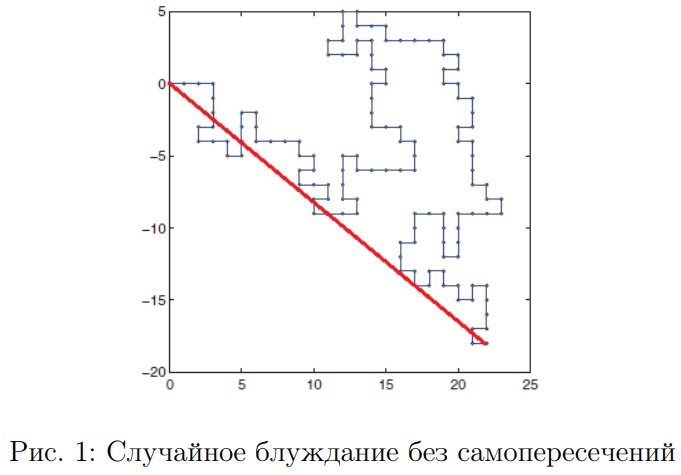

In [38]:
M = 17 # длина путей
N = 10000 # количество экспериментов

# направления: вверх, вниз, влево, вправо
directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
# функция нахождения расстояния от точки (x, y) до (0, 0)
def calculate_distance(x, y):
    return np.sqrt(x**2 + y**2)

In [39]:
def generate_saw(M):
    # начало - точка (0, 0)
    x, y = 0, 0
    path = [(x, y)]
    g = 1.0

    for k in range(M):
      # текущее положение - последняя точка в пройденном пути
      x, y = path[-1]

      # доступные направления для шага
      current_directions = []
      for d in directions:
        current_directions.append((x + d[0], y + d[1]))
      available_directions = [i for i in current_directions if i not in path]

      # если больше нет доступных направлений, возвращаем путь с нулевым весом
      if not available_directions:
        return path, 0.0

      # делаем шаг в случайном направлении
      chosen_direction = random.choice(available_directions)
      path.append(chosen_direction)

      # вспомогательное распределение
      # g(x) = П(1 / dk), k = 1..M
      g *= (1 / len(available_directions))

    # вес i-того пути
    # Wi = 1 / g(x)
    Wi = 1 / g
    return path, Wi


distances = []
weights = []

max_weight = -1
max_path = []

for i in range(N):
      path, Wi = generate_saw(M)
      distance = calculate_distance(path[-1][0], path[-1][1])
      distances.append(distance)
      weights.append(Wi)

      if Wi > max_weight:
        max_weight = Wi
        max_path = path


distances = np.array(distances)
weights = np.array(weights)

# общий вес
# g(x) = П(1 / dk), Wi = 1 / g(x)
# Wn = sum(Wi), i=1..N
total_weight = sum(weights)

# нормированные веса для каждого пути
# W~ = wi / Wn
norm_weights = np.array([wi / total_weight for wi in weights])

# среднее взвешенное
# sum(W~ * Δn)
weighted_mean = np.sum(norm_weights * distances)
print(f"Среднее расстояние: {weighted_mean:.4f}")

Среднее расстояние: 7.1348


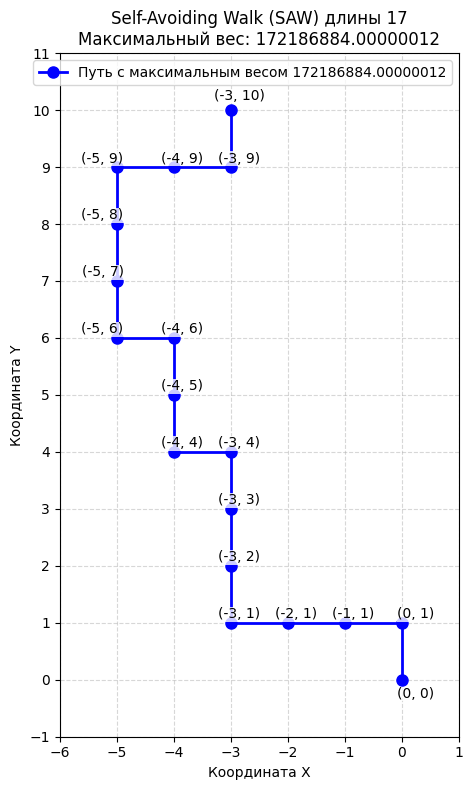

In [40]:
import matplotlib.pyplot as plt

# print(max_weight, max_path)
w, path = max_weight, max_path

# координаты
x_coords = [point[0] for point in path]
y_coords = [point[1] for point in path]

# границы графика с отступами
x_padding = 1 if (max(x_coords) - min(x_coords)) > 0 else 0.5
y_padding = 1 if (max(y_coords) - min(y_coords)) > 0 else 0.5

# график с динамическим размером
fig, ax = plt.subplots(figsize=(8, 8))

# путь
ax.plot(x_coords, y_coords, 'b-o', linewidth=2, markersize=8, label=f'Путь с максимальным весом {w}')

for i, (x, y) in enumerate(path):
    x_offset = 0.15
    y_offset = 0.15

    if x == min(x_coords): x_offset = -0.25
    if x == max(x_coords): x_offset = 0.25
    if y == min(y_coords): y_offset = -0.25
    if y == max(y_coords): y_offset = 0.25

    ax.text(x + x_offset, y + y_offset, f'({x}, {y})',
            fontsize=10, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=0.2))

ax.set_xticks(range(int(min(x_coords))-1, int(max(x_coords))+2))
ax.set_yticks(range(int(min(y_coords))-1, int(max(y_coords))+2))
ax.grid(True, linestyle='--', alpha=0.5)

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(min(x_coords)-x_padding, max(x_coords)+x_padding)
ax.set_ylim(min(y_coords)-y_padding, max(y_coords)+y_padding)

ax.set_title(f"Self-Avoiding Walk (SAW) длины {M}\nМаксимальный вес: {w}")
ax.set_xlabel("Координата X")
ax.set_ylabel("Координата Y")
ax.legend()

plt.tight_layout()
plt.show()

In [41]:
import random

# функция для визуализации SAW
def plot_saw(paths):
    plt.figure(figsize=(10, 8))
    
    for i, path in enumerate(paths):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)

        x = [p[0] for p in path]
        y = [p[1] for p in path]
        
        # отрисовка пути
        plt.plot(x, y, marker='o', linestyle='-', color="#{:02x}{:02x}{:02x}".format(r, g, b), markersize=5)#, label=f'Путь №{i+1}')
        
        # отрисовка линии расстояния от начала до конечной точки
        plt.plot([0, path[-1][0]], [0, path[-1][1]], linestyle='--', color="#{:02x}{:02x}{:02x}".format(r, g, b), alpha=0.5)#, label=f'Расстояние №{i+1}')
        
    plt.title(f"Случайное блуждание без самопересечений длины N={n}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    # plt.legend()
    plt.show()

## 2. Моделирование распространения излучения в многослойных средах

Рассматривается процесс распространения излучения в многослойных биологических тканях с оптическими параметрами, близкими к коже и подкожным тканям. Каждый слой характеризуется своим набором параметров: коэффициентом поглощения $\mu_a$, коэфициентом рассеяния $\mu_s$, фактором анизотропии $g$, толщиной $d$. Предполагается, что ткань содержит внутреннюю замкнутую неоднородность в виде шара радиуса $r$ с центром, расположенным на глубине $\ell$ от поверхности.

На поверхность биоткани падает (перпендикулярно поверхности) бесконечно тонкий световой пучок, так что направление падения пучка проходит через центр внутренней неоднородности (см. рис. 2 ). Оптические свойства биоткани представлены в таблице 1. 

\begin{aligned}
&\text { Таблица 1: Оптические параметры модели кожи для длины волны } \lambda=337 \text { нм }\\
&\begin{array}{|c|l|c|c|c|c|}
\hline \text { № } & \text { Слой } & \mu_a, \mathrm{~cm}^{-1} & \mu_s, \mathrm{~cm}^{-1} & g & d, \mathrm{~cm} \\
\hline 1 & \text { Эпидермис } & 32 & 165 & 0,72 & 0,01 \\
2 & \text { Папиллярная дерма } & 23 & 227 & 0,72 & 0,02 \\
3 & \text { Поверхностное сосудистое сплетение } & 40 & 246 & 0,72 & 0,02 \\
4 & \text { Ретикулярная дерма } & 23 & 227 & 0,72 & 0,09 \\
5 & \text { Глубокое сосудистое сплетение } & 46 & 253 & 0,72 & 0,06 \\
6 & \text { Неоднородность } & 51 & 186 & 0,8 & - \\
\hline
\end{array}
\end{aligned}
  
Моделирование распространения фотонов в многослойных средах проводится по
стандартной схеме [3]. При столкновении со структурными элементами биоткани фотоны могут рассеиваться или поглощаться. Вероятность поглощения равна  
$$
P_a=\frac{\mu_a}{\mu_a+\mu_s}
$$

Когда фотон рассеивается, его траектория отклоняется на угол $\theta \in[0, \pi]$. Плотность распределения с. в. $\cos \theta$ определяется так называемой фазовой функцией ХениГринштейна:
$$
p(\cos \theta)=\frac{1-g^2}{2\left(1+g^2-2 g \cos \theta\right)^{3 / 2}}
$$

где $g$ - фактор анизотропии. Также предполагается, что фотон отклоняется аксиальносимметрично относительно первоначального направления на азимутальный угол $\varphi \in[0,2 \pi]$. Пробег фотона между взаимодействиями распределен по показательному закону с параметром $\mu=\mu_a+\mu_s$ (для простоты предположим, что при прохождении через границу разделения слоев разыгрывать новую длину пробега не требуется). Отражения на границах слоев биоткани не учитываются.  

Каждому фотону приписывается статистический вес $W=1$. При очередном акте взаимодействия со средой статистический вес уменьшается на величину  
$$
\Delta W=W \frac{\mu_a}{\mu}
$$

Если статистический вес достиг порогового значения $W_{\text {П }}$, то с вероятностью $1 / m$ фотон может продолжить движение с новым весом $m W$, в противном случае фотон считается поглощенным. Поглощенная энергия, приходящаяся на некоторый участок биоткани, находится по следующей формуле
$$
Q=\frac{X q}{V}
$$

где $X$ - суммарный статистический вес, поглощенный на данном участке объема $V$; $q$ - энергия, которой соответствует полный статистический вес пакета фотонов.

Смоделировать траекторию движения $N$ фотонов и вычислить оценки следующих характеристик:
1. Коэффициенты пропускания (доля фотонов, прошедших через ткань) и отражения (доля отраженных фотонов) среды;
2. Распределение поглощенной энергии в плоскости сечения $x z$.
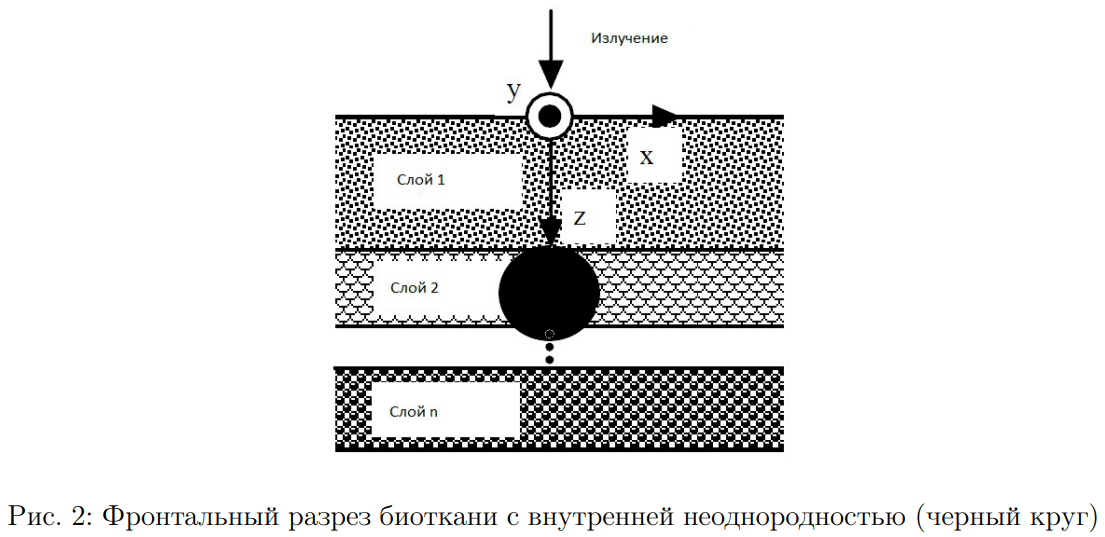

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform

# оптические параметры слоев
layers = [
    {"name": "Эпидермис", "mua": 32, "mus": 165, "g": 0.72, "d": 0.01},
    {"name": "Папиллярная дерма", "mua": 23, "mus": 227, "g": 0.72, "d": 0.02},
    {"name": "Поверхностное сосудистое сплетение", "mua": 40, "mus": 246, "g": 0.72, "d": 0.02},
    {"name": "Ретикулярная дерма", "mua": 23, "mus": 227, "g": 0.72, "d": 0.09},
    {"name": "Глубокое сосудистое сплетение", "mua": 46, "mus": 253, "g": 0.72, "d": 0.06}
]

l_max = sum(layer["d"] for layer in layers) # 0.2

sphere = {"name": "Неоднородность", "mua": 51, "mus": 186, "g": 0.8, "r": 0.01, "l": 0.02}

In [43]:
N = 10000 # количество фотонов
W_p = 0.00001 # пороговый вес
m = 10 # коэффициент увеличения веса для выживания фотонов

# координаты поглощенных фотонов
x_absorb = []
y_absorb = []
z_absorb = []

# границы по Х, Z
x_min, x_max = - sum(layer["d"] for layer in layers) - sphere["l"], sum(layer["d"] for layer in layers) + sphere["l"]
z_min, z_max = -sum(layer["d"] for layer in layers) - sphere["l"], 0.0

# размер ячейки сетки
dx, dz = 0.001, 0.001

# число ячеек по х и z, матрица для накопления поглощенной энергии
x_size = int((x_max - x_min) / dx)
z_size = int((z_max - z_min) / dz)
Q = np.zeros((x_size, z_size))

# счетчик фотонов, прошедших через всю среду
transmission_num = 0

# счетчик фотонов, отраженных обратно
reflection_num = 0

# в каком слое сейчас фотон?
def get_current_layer(z):
    for i, layer in enumerate(layers):
        current_d = sum(l["d"] for l in layers[:i + 1])
        if z < current_d:
            return layers[i]

# фотон в сфере-неоднородности?
def is_in_sphere(x, y, z):
  return (z - sphere["l"])**2 + x**2 + y**2 < sphere["r"]**2

# обратная функция Хени-Гринштейна
def func_HG(g):
    if g == 0:
        # изотропное рассеивание
        return 2 * uniform() - 1
    else:
        # анизотропное рассеивание
        return (1 / (2 * g)) * (1 + g**2 - ((1 - g**2) / (1 - g + 2 * g * uniform()))**2)


for _ in range(N):
    # 1. запуск фотона с точки (0, 0, 0)
    x, y, z = 0, 0, 0

    # запускаем перпендикулярно оси z
    V = np.array([0, 0, -1])

    # начальный вес фотона (в чем измеряется вес светлой мысли?)
    W = 1

    # запускаем в первый слой, получаем его характеристики
    layer = layers[0]
    mua, mus, g = layer["mua"], layer["mus"], layer["g"]

    while True:
        # 2. генерация свободного пробега
        # длина свободного пробега фотона распределена экспоненциально с параметром μi = μai + μsi
        s = np.random.exponential(1 / (mua + mus))

        # перемещаем фотон
        x = x + V[0] * s
        y = y + V[1] * s
        z = z + V[2] * s

        # 3. проверка на пересечение границ, расчет расстояния (прошел ли все слои отразившись или пройдя насквозь? поглотился или рассеялся?)
        in_sphere = is_in_sphere(x, y, z)

        # если фотон не в сфере и вышел вниз за пределы всех слоев (текущее z меньше минимального), он прошел через ткань
        if z < z_min and not (in_sphere):
            transmission_num += 1
            break

        # иначе если фотон не в сфере и вышел вверх за пределы, он отразился (z больше нуля)
        if z > 0 and not (in_sphere):
            reflection_num += 1
            break

        # иначе ищем в каком слое находится фотон
        # получаем параметры в зависимости от слоя: неоднородность или другой слой
        if in_sphere:
            mua, mus, g = sphere["mua"], sphere["mus"], sphere["g"]
        else:
            layer = get_current_layer(z)
            mua, mus, g = layer["mua"], layer["mus"], layer["g"]

        # вероятность поглощения фотона при столкновении со структурными элементами среды равна Pai = μai / μai + μsi
        # если выполняется, фотон ПОГЛОЩАЕТСЯ и его энергия сохраняется
        if uniform() < mua / (mua + mus):
            i = int((x - x_min) / dx)
            j = int((z - z_min) / dz)
            if 0 <= i < x_size and 0 <= j < z_size:
                Q[i, j] += W / N
            x_absorb.append(x)
            y_absorb.append(y)
            z_absorb.append(z)
            break

        # иначе фотон РАССЕЯЛСЯ
        else:
            cos_theta = func_HG(g)

            # угол рассеяния
            theta = np.arccos(cos_theta)
            # азимутальный угол
            phi = 2 * np.pi * uniform()

            # если летел строго вертикально - сферические координаты
            if abs(V[2]) == 1:
                V = np.array([
                    np.sin(theta) * np.cos(phi),
                    np.sin(theta) * np.sin(phi),
                    V[2] * np.cos(theta)
                ])
            # иначе поворот в 3д пространстве
            else:
                V_0_old = V[0]
                V[0] = V[0] * np.cos(theta) + (np.sin(theta) / np.sqrt(1 - V[2]**2)) * (V[0] * V[2] * np.cos(phi) - V[1] * np.sin(phi))
                V[1] = V[1] * np.cos(theta) + (np.sin(theta) / np.sqrt(1 - V[2]**2)) * (V[1] * V[2] * np.cos(phi) + V_0_old * np.sin(phi))
                V[2] = V[2] * np.cos(theta) - np.sin(theta) * np.cos(phi) * np.sqrt(1 - V[2]**2)

        # изменение веса фотона при взаимодействии со средой
        delta_W = W * mua / (mua + mus)
        W = W - delta_W

        # 4. поглощен ли фотон?
        # сравнение с пороговым весом
        if W < W_p:
            # вес меньше порогового - "рулетка выживания"
            if uniform() < 1 / m:
                # фотон выжил, продолжает движение с весом W*m
                W *= m
            else:
                # фотон поглощается
                i = int((x - x_min) / dx)
                j = int((z - z_min) / dz)
                if 0 <= i < x_size and 0 <= j < z_size:
                    Q[i, j] += W / N
                x_absorb.append(x)
                y_absorb.append(y)
                z_absorb.append(z)
                break
        # иначе предельный вес не достигнут, продолжается движение

print(transmission_num)
print(reflection_num)

# результаты
transmission_coefficient = transmission_num / N
reflection_coefficient = reflection_num / N
print(f"Коэффициент пропускания: {transmission_coefficient}")
print(f"Коэффициент отражения: {reflection_coefficient}")

0
1142
Коэффициент пропускания: 0.0
Коэффициент отражения: 0.1142


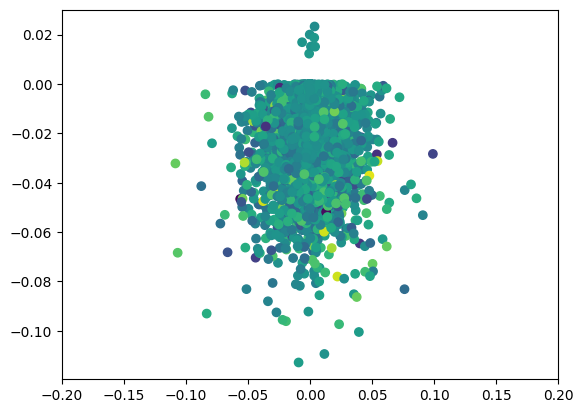

In [44]:
plt.scatter(x_absorb, z_absorb, c = y_absorb)
plt.xlim(-0.2, 0.2)
plt.show()

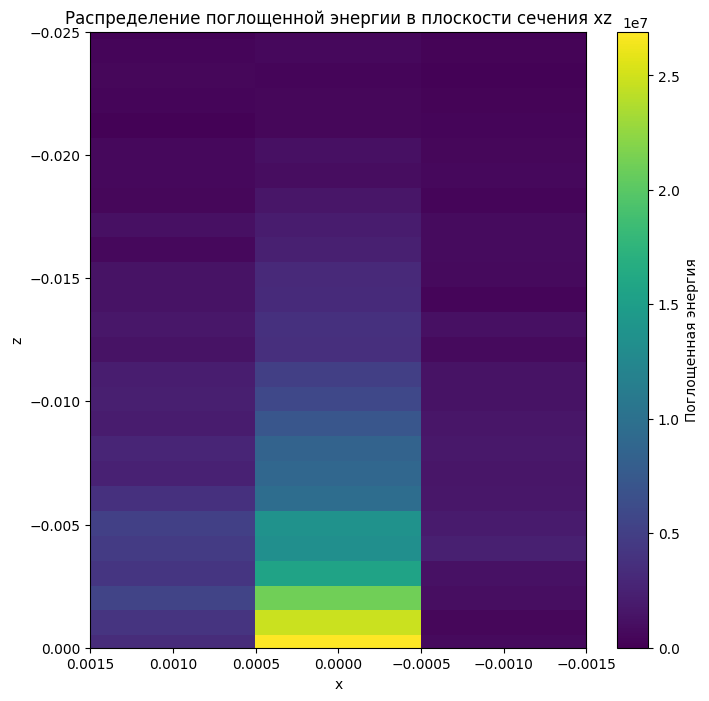

In [45]:
# нормализация поглощенной энергии

# толщина слоя в направлении y
dy = 0.001

# объем ячейки
V = dx * dz * dy

# энергия фотона
q = 1

# энергия на единицу объема
Q_normalized = (Q * q) / V

# визуализация распределения поглощенной энергии
x = np.linspace(x_min, x_max, x_size)
z = np.linspace(z_min, z_max, z_size)
X, Z = np.meshgrid(x, z)
plt.figure(figsize=(8, 8))
plt.pcolormesh(X, Z, Q_normalized.T, shading='auto', cmap='viridis')
plt.colorbar(label='Поглощенная энергия')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Распределение поглощенной энергии в плоскости сечения xz')
plt.ylim(0,-0.025)
plt.xlim(0.0015,-0.0015)

plt.show()